In [1]:
import numpy as np
import sklearn.datasets
import random
import math
from skimage.measure import block_reduce
from scipy.signal import convolve

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)
X = ((X / 255) - 0.5) * 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)

In [55]:
import numpy as np
import sys

class MLP(object):
    
    def __init__(self, n_hidden=30, n_hidden2=30,
                 l2=0., epochs=10, minibatch_size=1, eta=0.001,
                 shuffle=True, seed=None, in_dim = [1, 28, 28], filter_dim = [1, 1, 5, 5], 
                 pool_dim=None, conv_stride=1):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.n_hidden2 = n_hidden2
        self.l2 = l2
        self.epochs = epochs
        self.minibatch_size = minibatch_size
        self.eta = eta
        self.shuffle = shuffle
        self.in_dim = in_dim
        self.filter_dim = filter_dim
        self.pool_dim = pool_dim
        self.conv_stride = conv_stride

    def _onehot(self, y, n_classes):
        
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _ReLU(self, z):

        return np.maximum(np.clip(z, -250, 250), 0)

    def _forward(self, X):
        
        X = X.values.reshape(len(X), self.in_dim[0], self.in_dim[-2], self.in_dim[-1], order='C')
        activation = len(X)*[0]
        for k in range(len(X)):
            activation[k] = self._ReLU(np.array([convolve(X[k], w, mode='valid') for w in self.W_c]) + self.b_c.reshape(1, -1, 1))

            if self.pool_dim: 
                activation[k] = block_reduce(activation[k], block_size=tuple([1] + list(self.pool_dim)), func=np.max)
        activation = np.array(activation)
        
        a_c = activation.reshape(len(X), -1, order='C')
        
        z_h = np.dot(a_c, self.w_h) + self.b_h

        a_h = self._ReLU(z_h)
        
        z_h2 = np.dot(a_h, self.w_h2) + self.b_h2
        
        a_h2 = self._ReLU(z_h2)

        z_out = np.dot(a_h2, self.w_out) + self.b_out

        a_out = self._ReLU(z_out)

        return a_c, z_h, a_h, z_h2, a_h2, z_out, a_out

    def _cost(self, y_enc, output):

        cost = np.sum((y_enc - output)**2) + \
                      self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_h2 ** 2.) + np.sum(self.w_out ** 2.))

        return cost

    def predict(self, X):
        
        a_c, z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        
        n_output = np.unique(y_train).shape[0]
        if self.pool_dim:
            out_dim = (self.filter_dim[0], int(round(((0.0 + self.in_dim[-2] - self.filter_dim[-2]) / self.conv_stride + 1) / self.pool_dim[-2])),
                    int(round(((0.0 + self.in_dim[-1] - self.filter_dim[-1]) / self.conv_stride + 1) / self.pool_dim[-1])))
        else:
            out_dim = [self.filter_dim[0], int(round(((0.0 + self.in_dim[-2] - self.filter_dim[-2]) / self.conv_stride + 1))), 
                   int(round(((0.0 + self.in_dim[-1] - self.filter_dim[-1]) / self.conv_stride + 1)))]
        n_features = out_dim[0] * out_dim[1] * out_dim[2]

        # Weight initialization
        self.W_c = np.random.randn(*self.filter_dim) * np.sqrt(2.0 / (sum(self.filter_dim)))
        self.b_c = np.zeros((int((self.in_dim[-1] - self.filter_dim[-1]) / self.conv_stride + 1), 1))

        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        
        self.b_h2 = np.zeros(self.n_hidden2)
        self.w_h2 = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, self.n_hidden2))

        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden2, n_output))

        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        for j in range(self.epochs):

            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                a_c, z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X_train.iloc[batch_idx])

                # Backpropagation

                delta_out = a_out - y_train_enc[batch_idx]

                ReLU_derivative_h = np.maximum(a_h, 0) / np.maximum(a_h, 1)
                
                ReLU_derivative_h2 = np.maximum(a_h2, 0) / np.maximum(a_h2, 1)
                
                ReLU_derivative_c = np.maximum(a_c, 0) / np.maximum(a_c, 1)

                delta_h2 = (np.dot(delta_out, self.w_out.T) * ReLU_derivative_h2)
                
                delta_h = (np.dot(delta_h2, self.w_h2.T) * ReLU_derivative_h)
                
                delta = (np.dot(delta_h, self.w_h.T) * ReLU_derivative_c)
                
                delta_new = self.minibatch_size*[0]
                grad_W_c = self.minibatch_size*[0]
                grad_b_c = self.minibatch_size*[0]
                
                x = np.copy(X_train.iloc[batch_idx].values)
                
#                 for i in range(self.minibatch_size):
#                     delta_new[i] = delta[i].reshape(len(self.W_c), 1, int((np.prod(delta[i].shape) // len(self.W_c)) ** 0.5), -1)
#                     if self.pool_dim: 
#                         delta_new[i] = delta[i].repeat(self.pool_dim[-2], axis=2).repeat(self.pool_dim[-1], axis=3)
#                     grad_W_c[i] = np.array([np.rot90(convolve(x[i].reshape(1, self.in_dim[-2], self.in_dim[-1]), np.rot90(d, 2), mode='valid'), 2) for d in delta_new[i]])
#                     grad_b_c[i] = np.sum(np.array([np.sum(d, axis=(1, )).reshape(-1, 1) for d in delta_new[i]]), axis=0)
                    
#                 d_W_c = np.array(grad_W_c)
#                 d_b_c = np.array(grad_b_c)
                
                
#                 grad_W_c = d_W_c[j]
#                 grad_b_c = d_b_c[j]
    
#                 grad_W_c = np.mean(d_W_c, axis = 0)
#                 grad_b_c = np.mean(d_b_c, axis = 0)

                delta_new = delta[j].reshape(len(self.W_c), 1, int((np.prod(delta[j].shape) // len(self.W_c)) ** 0.5), -1)
                if self.pool_dim: 
                   delta_new = delta_new.repeat(self.pool_dim[-2], axis=2).repeat(self.pool_dim[-1], axis=3)
                grad_W_c = np.array([np.rot90(convolve(x[j].reshape(1, self.in_dim[-2], self.in_dim[-1]), np.rot90(d, 2), mode='valid'), 2) for d in delta_new])
                grad_b_c = np.sum(np.array([np.sum(d, axis=(1, )).reshape(-1, 1) for d in delta_new]), axis=0)
                
                

                delta_W_c = (grad_W_c + self.l2*self.W_c)
                delta_b_c = grad_b_c
                
                self.W_c -= self.eta * delta_W_c
                self.b_c -= self.eta * delta_b_c

                grad_w_h = np.dot(a_c.T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)
                
                grad_w_h2 = np.dot(a_h.T, delta_h2)
                grad_b_h2 = np.sum(delta_h2, axis=0)

                grad_w_out = np.dot(a_h2.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h
                
                delta_w_h2 = (grad_w_h2 + self.l2*self.w_h2)
                delta_b_h2 = grad_b_h2
                
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                self.w_h2 -= self.eta * delta_w_h2
                self.b_h2 -= self.eta * delta_b_h2

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            # Evaluation

            a_c, z_h, a_h, z_h2, a_h2, z_out, a_out = self._forward(X_train)
            
            cost = self._cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])

            sys.stdout.write('\r%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (j+1, cost, train_acc*100, valid_acc*100))
            sys.stdout.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [56]:
nn = MLP(n_hidden=128, n_hidden2=64, l2=0.05, epochs=10, minibatch_size=100, eta=0.0005, shuffle=True, seed=1, 
         in_dim = [1, 28, 28], filter_dim = [3, 1, 5, 5], pool_dim=[1, 2, 2], conv_stride=1)

In [57]:
%%time
nn.fit(X_train[:55000], y_train[:55000], X_train[55000:], y_train[55000:])

10 | Cost: 6195.01 | Train/Valid Acc.: 95.07%/93.96% Wall time: 22min 38s


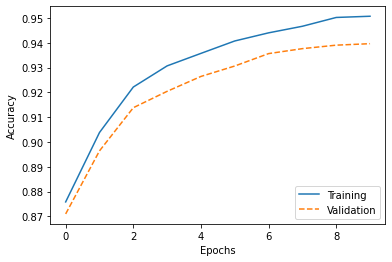

In [58]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [59]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 94.86%
